In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error

Unnamed: 0      0
Store           0
Date            0
IsHoliday       0
Dept            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64
          Unnamed: 0          Store      IsHoliday           Dept  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean   211611.321278      22.200546       0.070358      44.260317   
std    122195.149363      12.785297       0.255750      30.492054   
min         0.000000       1.000000       0.000000       1.000000   
25%    105782.250000      11.000000       0.000000      18.000000   
50%    211603.500000      22.000000       0.000000      37.000000   
75%    317424.750000      33.000000       0.000000      74.000000   
max    423285.000000      45.000000       1.000000      99.000000   

        Weekly_Sales    Temperature     Fuel_Price      Mar

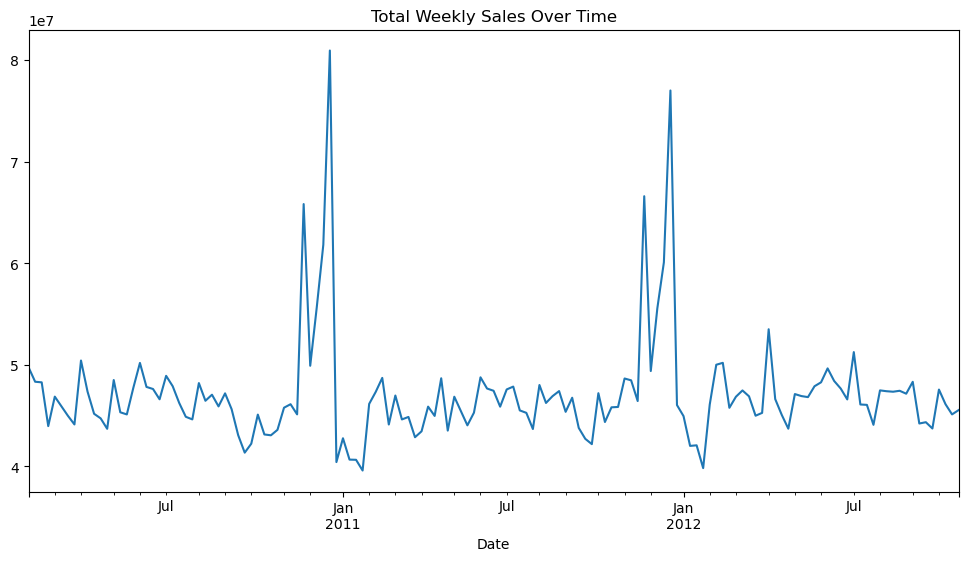

In [2]:
#load and preview
df = pd.read_csv('walmart_cleaned.csv')
print(df.info())
print(df.head())

#check for missing values
print(df.isnull().sum())

#convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

#plot sales over time
plt.figure(figsize=(12,6))
df.groupby('Date')['Weekly_Sales'].sum().plot()
plt.title('Total Weekly Sales Over Time')
plt.show()

In [4]:
#aggregate weekly sales by date
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

#train-test split
train_size = int(len(weekly_sales) * 0.8)
train, test = weekly_sales[:train_size], weekly_sales[train_size:]
print("done")

done


ADF Statistic: -5.273240474947424
p-value: 6.219568401203441e-06


/Users/yong/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37778D+00    |proj g|=  3.05988D+00

At iterate    5    f=  8.78247D+00    |proj g|=  1.22500D+00

At iterate   10    f=  8.70477D+00    |proj g|=  4.20832D-02

At iterate   15    f=  8.70476D+00    |proj g|=  2.90842D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     21      1     0     0   7.015D-05   8.705D+00
  F =   8.7047574558721941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

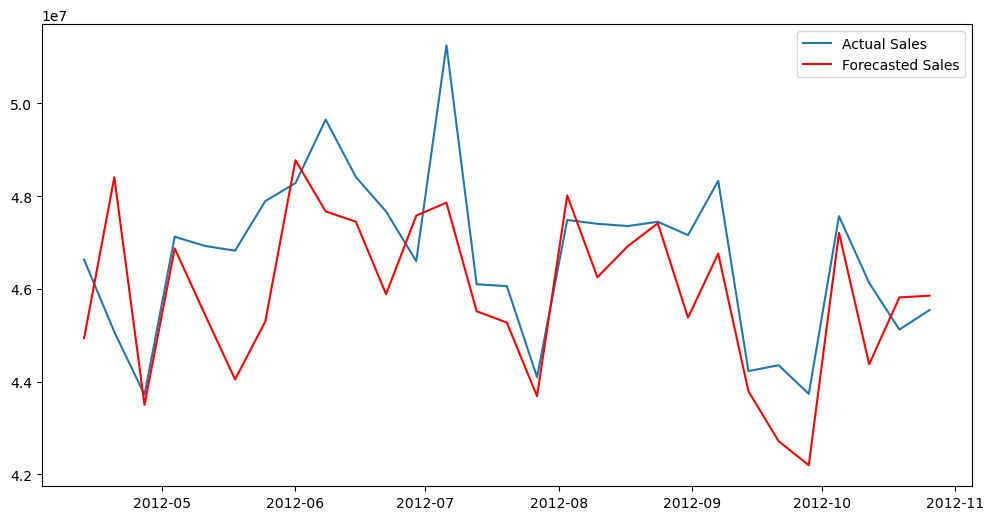

In [25]:
#SARIMAX model fitting

#stationarity test
result = adfuller(train['Weekly_Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#fit SARIMAX model
#model = ARIMA(train['Weekly_Sales'], order=(5,1,0))
model = SARIMAX(train['Weekly_Sales'], order=(3, 0, 1), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit()
print(model_fit.summary())

#forecast
forecast = model_fit.forecast(steps=len(test))

#plot results
plt.figure(figsize=(12,6))
plt.plot(test['Date'], test['Weekly_Sales'], label='Actual Sales')
plt.plot(test['Date'], forecast, label='Forecasted Sales', color='red')
plt.legend()
plt.show()

Epoch 1/75
4/4 [==============================] - 2s 163ms/step - loss: 0.0536
Epoch 2/75
4/4 [==============================] - 0s 30ms/step - loss: 0.0486
Epoch 3/75
4/4 [==============================] - 0s 29ms/step - loss: 0.0436
Epoch 4/75
4/4 [==============================] - 0s 26ms/step - loss: 0.0392
Epoch 5/75
4/4 [==============================] - 0s 24ms/step - loss: 0.0343
Epoch 6/75
4/4 [==============================] - 0s 26ms/step - loss: 0.0295
Epoch 7/75
4/4 [==============================] - 0s 26ms/step - loss: 0.0252
Epoch 8/75
4/4 [==============================] - 0s 24ms/step - loss: 0.0227
Epoch 9/75
4/4 [==============================] - 0s 24ms/step - loss: 0.0209
Epoch 10/75
4/4 [==============================] - 0s 23ms/step - loss: 0.0205
Epoch 11/75
4/4 [==============================] - 0s 23ms/step - loss: 0.0205
Epoch 12/75
4/4 [==============================] - 0s 24ms/step - loss: 0.0217
Epoch 13/75
4/4 [==============================] - 0s 24ms/s

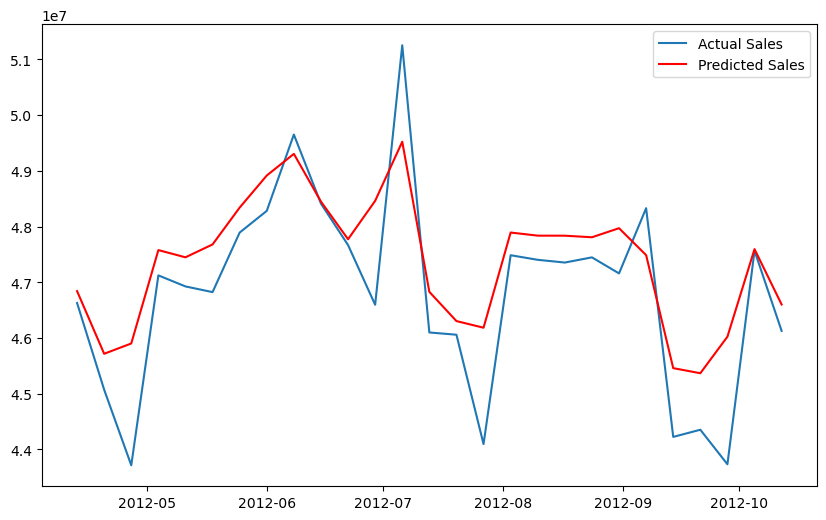

In [79]:
#LSTM model fitting

#normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Weekly_Sales'].values.reshape(-1,1))

#prepare input sequences for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)
seq_length = 2
x_train, y_train = create_sequences(train_scaled, seq_length)

#reshape for LSTM
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

#build LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#train the model
model.fit(x_train, y_train, epochs=75, batch_size=32)

#forecast on test data
test_scaled = scaler.transform(test['Weekly_Sales'].values.reshape(-1,1))
x_test, y_test = create_sequences(test_scaled, seq_length)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#determine the length difference
len_difference = len(test['Weekly_Sales']) - len(predictions.flatten())

#plot
plt.figure(figsize=(10,6))
plt.plot(test['Date'][:len(predictions)], test['Weekly_Sales'][:len(predictions)], label='Actual Sales')
plt.plot(test['Date'][:len(predictions)], predictions.flatten(), label='Predicted Sales', color='red')
plt.legend()
plt.show()

In [80]:
#SARIMAX error
sarimax_error = np.sqrt(mean_squared_error(test['Weekly_Sales'], forecast))
print(f'ARIMA RMSE: {sarimax_error}')

#LSTM error
lstm_error = np.sqrt(mean_squared_error(test['Weekly_Sales'][seq_length:], predictions))
print(f'LSTM RMSE: {lstm_error}')

ARIMA RMSE: 1543122.5288370317
LSTM RMSE: 1944393.8470282976


In [39]:
#save to csv
min_len = len(predictions.flatten())

forecast_data = pd.DataFrame({
    'Date': test['Date'].iloc[:min_len],
    'Actual Sales': test['Weekly_Sales'].iloc[:min_len],
    'ARIMA Forecast': forecast[:min_len],
    'LSTM Forecast': predictions.flatten()
})
forecast_data.to_csv('forecast_results.csv', index=False)

